<a href="https://colab.research.google.com/github/AdamChoong0095/NUS-Stock-Data/blob/Adam/Stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price CS3244 project
The goals of this project are:
* To determine an effective model with justificaiton for predicting stock prices of the S&P500
* To determine if the S&P500 is a good indicator of performance for other companies contained in the top 500 performing companies

In [452]:
#from google.colab import drive
#drive.mount('/content/drive')

In [453]:
import pandas as pd
sp500=pd.read_csv('spy.us.txt')

# Create empty lists to store the new data
dates = []
prices = []
price_types = []

# Iterate through the DataFrame
for index, row in sp500.iterrows():
  date = row['Date']
  open_price = row['Open']
  high_price = row['High']
  low_price = row['Low']
  close_price = row['Close']

  # Append the data to the lists
  dates.extend([date] * 4)  # Repeat the date 4 times
  prices.extend([open_price, high_price, low_price, close_price])
  price_types.extend(['open', 'high', 'low', 'close'])

# Create a new DataFrame
sp500 = pd.DataFrame({'Date': dates, 'Price': prices, 'Type of Price': price_types})

In [454]:
# Group the DataFrame by Date and Type of Price
grouped = sp500.groupby(['Date', 'Type of Price'])

# Calculate the average price for each date and type
avg_prices = grouped['Price'].mean().reset_index()

# Create a dictionary to store the average high and low prices for each date
avg_high_low = {}

# Iterate through the average prices
for index, row in avg_prices.iterrows():
  date = row['Date']
  price_type = row['Type of Price']
  price = row['Price']

  if date not in avg_high_low:
    avg_high_low[date] = {}

  if price_type == 'high' or price_type == 'low':
    avg_high_low[date][price_type] = price

# Iterate through the DataFrame and replace high and low prices with the average
for index, row in sp500.iterrows():
  date = row['Date']
  price_type = row['Type of Price']

  if price_type == 'high' or price_type == 'low' and date in avg_high_low:
    sp500.loc[index, 'Price'] = avg_high_low[date][price_type]


In [455]:
# Create a new DataFrame to store the modified data
new_sp500 = pd.DataFrame(columns=['Date', 'Price', 'Type of Price'])

# Iterate through the DataFrame
i = 0
while i < len(sp500):
  row = sp500.iloc[i]
  if row['Type of Price'] == 'high':
    # Check if the next row exists and is 'low'
    if i + 1 < len(sp500) and sp500.iloc[i + 1]['Type of Price'] == 'low':
      # Calculate the average of the high and low prices
      average_price = (row['Price'] + sp500.iloc[i + 1]['Price']) / 2
      # Add a new row with the average price and label 'average'
      new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [average_price], 'Type of Price': ['average']})], ignore_index=True)
      i += 2  # Skip the next row (low)
    else:
      # If the next row is not 'low', keep the current row as it is
      new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [row['Price']], 'Type of Price': [row['Type of Price']]})], ignore_index=True)
      i += 1
  else:
    # If the current row is not 'high', keep it as it is
    new_sp500 = pd.concat([new_sp500, pd.DataFrame({'Date': [row['Date']], 'Price': [row['Price']], 'Type of Price': [row['Type of Price']]})], ignore_index=True)
    i += 1

new_dates = []
for index, row in new_sp500.iterrows():
  date = row['Date']
  price_type = row['Type of Price']
  if price_type == 'open':
    new_dates.append(date + '-09:30')
  elif price_type == 'average':
    new_dates.append(date + '-13:30')
  else:
    new_dates.append(date + '-16:30')

new_sp500['Date'] = new_dates
sp500=new_sp500
sp500

,Date,Price,Type of Price
0,2005-02-25-09:30,104.770,open
1,2005-02-25-13:30,105.340,average
2,2005-02-25-16:30,105.790,close
3,2005-02-28-09:30,105.550,open
4,2005-02-28-13:30,105.120,average
...,...,...,...
9598,2017-11-09-13:30,257.375,average
9599,2017-11-09-16:30,258.170,close
9600,2017-11-10-09:30,257.730,open
9601,2017-11-10-13:30,257.790,average


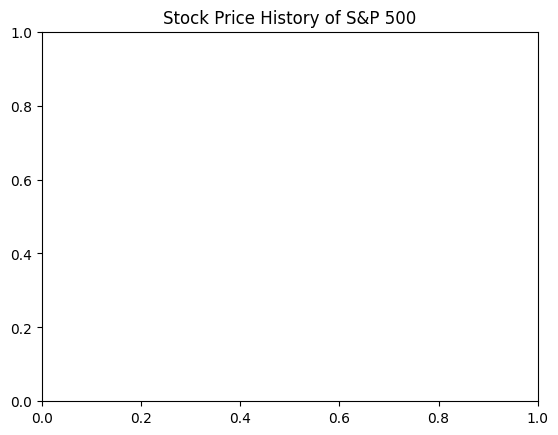

In [456]:
import seaborn as sns
import matplotlib.pyplot as plt

impute = True

if not impute:
    sp500.drop(sp500[sp500['Type of Price'] == 'average'].index, inplace=True)

graph_sp500_prices=sp500.drop(columns='Type of Price')
#sns.lineplot(data=graph_sp500_prices,x='Date',y='Price')
plt.title('Stock Price History of S&P 500')
plt.show()

## Method
To achieve the first goal, we will tune hyperparameters of different models to achieve the best performance possible for each type of model (based on multiple metrics)
* Split data into 80/20 proportion (4 years of training to predict 1 year of prices) to mitigate the effect of overfitting or underfitting. For training/validation, we try cross validation on time series (recommended but more computationally expensive, see code below)
* Select models appropriate for the time series context.
* Compare between model types and ascertain the best model for predicting prices based on a standardised set of metrics.
* Apply the selected model to an assortment of companies contained in the S&P500.
* The purpose of doing this will be to demonstrate whether or not this approach of model selection generalises well on stock price prediction.

The reasoning behind this approach is that the S&P500 is a traditional indicator (by definition) of the performance of the 500 most dominant stocks in Wall Street.

In [457]:
#perform unique time series cross validation (instead of stochastic selection of subsets, we select ordered subsets to train and validate models)
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
train_size = int(len(sp500) * 0.8)
sp500.drop(columns=['Type of Price'],inplace=True)
sp500_train = sp500[:train_size]
sp500_test = sp500[train_size:]
tscv=TimeSeriesSplit(n_splits=5)
cv_data=[]
for train_idx,validate_idx in tscv.split(sp500_train):
  train=sp500_train.iloc[train_idx]
  validate=sp500_train.iloc[validate_idx]
  cv_data.append((train,validate))

We will only focus on time series specific modelling techniques that can capture the sequential nature of our data because of our project's method which is to use historical prices to predict future prices. This means models like SVR or random forests which generally perform poorly when trying to capture trends in time series data will be excluded. Further reasoning for excluding these models is also because of the lack of other features than price, volume (which we exclude because of our lack of justificaiton or understanding for including this feature) and date

In [ ]:
from datetime import datetime
import math

train_train_size = int(train_size * 0.8)

Timestamp = []
quarter = []
first = datetime.strptime(sp500['Date'][0], '%Y-%m-%d-%H:%M').timestamp()
for index, row in sp500.iterrows():
  date = row['Date']
  t = datetime.strptime(date, '%Y-%m-%d-%H:%M').timestamp()

  Timestamp.append(t-first)
  quarter.append(math.ceil(datetime.strptime(date, '%Y-%m-%d-%H:%M').month/3.))


sp500['Timestamp'] = Timestamp
sp500['Quarter'] = quarter
sp500 = pd.get_dummies(sp500,columns=['Quarter'], dtype=int)
sp500['Constant'] = np.ones(len(sp500))
sp500['logPrice'] = np.log(sp500['Price'])
sp500['prevPrice'] = sp500['Price'].shift(1)
sp500['prev2Price'] = sp500['Price'].shift(2)
sp500['prev3Price'] = sp500['Price'].shift(3)
sp500['prevlogPrice'] = sp500['logPrice'].shift(1)
sp500['prev2logPrice'] = sp500['logPrice'].shift(2)
sp500['prev3logPrice'] = sp500['logPrice'].shift(3)
sp500['prevTimestamp'] = sp500['Timestamp'].shift(1)
sp500['t'] = sp500['Timestamp'] - sp500['prevTimestamp']
sp500['pctChange'] = (sp500['Price'] / sp500['prevPrice'] -1) * 100
sp500['prevpctChange'] = sp500['pctChange'].shift(1)
sp500 = sp500.dropna()

print(sp500)


                  Date    Price    Timestamp  Quarter_1  Quarter_2  Quarter_3   
3     2005-02-28-09:30  105.550     259200.0          1          0          0  \
4     2005-02-28-13:30  105.120     273600.0          1          0          0   
5     2005-02-28-16:30  105.080     284400.0          1          0          0   
6     2005-03-01-09:30  105.220     345600.0          1          0          0   
7     2005-03-01-13:30  105.545     360000.0          1          0          0   
...                ...      ...          ...        ...        ...        ...   
9598  2017-11-09-13:30  257.375  400910400.0          0          0          0   
9599  2017-11-09-16:30  258.170  400921200.0          0          0          0   
9600  2017-11-10-09:30  257.730  400982400.0          0          0          0   
9601  2017-11-10-13:30  257.790  400996800.0          0          0          0   
9602  2017-11-10-16:30  258.090  401007600.0          0          0          0   

      Quarter_4  Constant  

['Constant', 'prevPrice', 'prev2Price', 'Timestamp', 't', 'Quarter_1', 'Quarter_2', 'Quarter_3', 'Quarter_4']
['Constant', 'prevPrice', 'prev2Price', 'Timestamp', 't', 'Quarter_1', 'Quarter_2', 'Quarter_3']
['Constant', 'prevPrice', 'prev2Price', 'Timestamp', 't', 'Quarter_2', 'Quarter_3']
['Constant', 'prevPrice', 'prev2Price', 'Timestamp', 't', 'Quarter_3']
['prevPrice', 'prev2Price', 'Timestamp', 't', 'Quarter_3']
['prevPrice', 'prev2Price', 'Timestamp', 't']
['prevPrice', 'prev2Price', 'Timestamp']
['prevPrice', 'prev2Price']
['prevPrice']
[0.4646615142417899, 0.463965630723109, 0.46396563070547603, 0.4637658530297276, 0.46369279199651053, 0.4636927910408538, 0.4636954282066775, 0.46375256973221995, 0.46596426421785525, 0.46806675934218506]


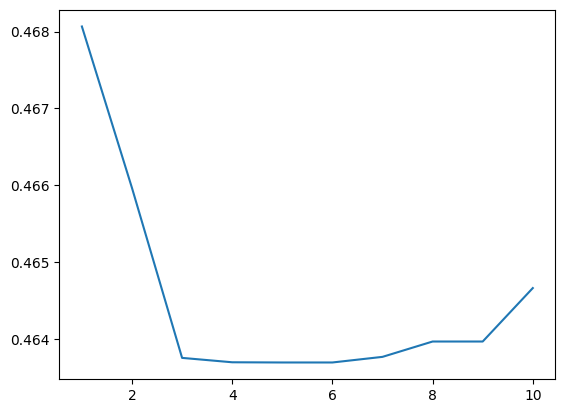

In [459]:
from sklearn import linear_model
log = False
if log:
    X_labels = ['Constant', 'prevlogPrice', 'prev2logPrice', 'prev3logPrice', 'Timestamp', 't', 'Quarter_1', 'Quarter_2', 'Quarter_3', 'Quarter_4' ]
    y = sp500[:train_train_size]['logPrice']
else:
    X_labels = ['Constant', 'prevPrice', 'prev2Price', 'prev3Price', 'Timestamp', 't', 'Quarter_1', 'Quarter_2', 'Quarter_3', 'Quarter_4' ]
    y = sp500[:train_train_size]['Price']

loss = []

def lossfunc(labels):
    regr = linear_model.LinearRegression()
    X = sp500[:train_train_size][labels]
    regr.fit(X, y)


    predicted = regr.predict(sp500[labels])
    if log:
        abserror = abs(np.exp(predicted)-sp500['Price'])
    else:
        abserror = abs(predicted-sp500['Price'])
    return abserror[train_train_size:train_size].mean()
    
goals = []

for i in range(len(X_labels)-1):
    
    goal = lossfunc(X_labels)
    goals.append(goal)
    tests = []
    for j in range(len(X_labels)):
        newlabels = [x for x in X_labels if x != X_labels[j]]
        loss = lossfunc(newlabels)
        tests.append(loss)

    argmax = min(enumerate(tests), key=lambda x: x[1])[0]
    del X_labels[argmax]
    print(X_labels)

goals.append(lossfunc(X_labels))
print(goals)

plt.plot(list(range(len(goals),0,-1)), goals)  # Plot the chart
plt.show()  # display

constant: 0.013404329270258586
coefficients: [ 1.09200896e+00 -9.22713273e-02  1.86499788e-10]
MAE: 0.5433000047733751
MSE: 0.6661548935978064


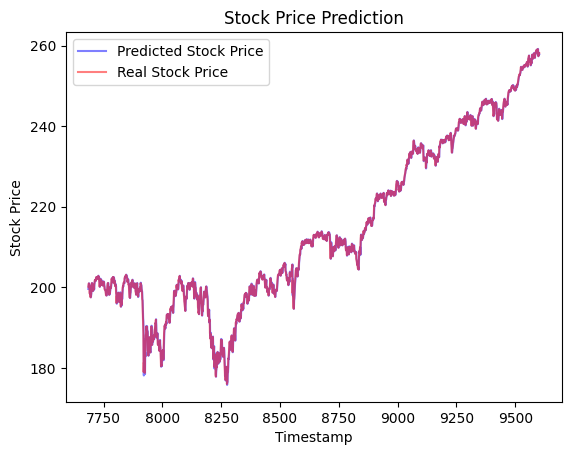

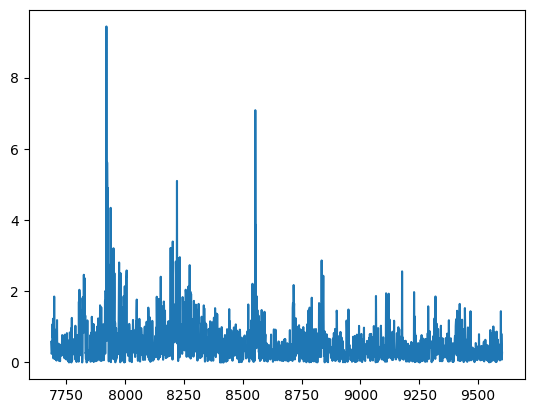

In [460]:
log = False
if log:
    X_labels = ['prevlogPrice', 'prev2logPrice', 'Timestamp']
    y = sp500[:train_size]['logPrice']
else:
    X_labels = ['prevPrice', 'prev2Price', 'Timestamp']
    y = sp500[:train_size]['Price']

regr = linear_model.LinearRegression()
X = sp500[:train_size][X_labels]
regr.fit(X, y)
print(f"constant: {regr.intercept_}")
print(f"coefficients: {regr.coef_}")
if log: 
    sp500['predicted'] = np.exp(regr.predict(sp500[X_labels]))
else:
    sp500['predicted'] = regr.predict(sp500[X_labels])


sp500['error'] = sp500['predicted']-sp500['Price']
plt.plot(sp500[train_size:]['predicted'], alpha=0.5, color='blue', label='Predicted Stock Price')

sp500['abserror'] = abs(sp500['error'])
sp500['squarederror'] = sp500['abserror'] **2

print(f"MAE: {sp500['abserror'][train_size:].mean()}")
print(f"MSE: {sp500['squarederror'][train_size:].mean()}")


plt.plot(sp500[train_size:]['Price'], alpha=0.5, color='red', label='Real Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Timestamp')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
plt.plot(sp500[train_size:]['abserror'])

plt.show()

            Date    Open    High     Low   Close    Volume  Constant   
0     2005-02-25  104.77  106.00  104.68  105.79  70221808       1.0  \
1     2005-02-28  105.55  105.68  104.56  105.08  79695344       1.0   
2     2005-03-01  105.22  105.87  105.22  105.62  54607412       1.0   
3     2005-03-02  105.21  106.22  105.10  105.57  73733090       1.0   
4     2005-03-03  105.99  106.20  105.15  105.61  71286823       1.0   
...          ...     ...     ...     ...     ...       ...       ...   
3195  2017-11-03  257.77  258.50  257.30  258.45  59578151       1.0   
3196  2017-11-06  258.30  259.00  258.22  258.85  49529148       1.0   
3197  2017-11-07  258.97  259.35  258.11  258.67  57218448       1.0   
3198  2017-11-08  258.47  259.22  258.15  259.11  50277699       1.0   
3199  2017-11-09  257.73  258.39  256.36  258.17  94537282       1.0   

      Timestamp  Quarter  nextOpen  ...  nextQuarter_1.0  nextQuarter_2.0   
0             0        1    105.55  ...                1  

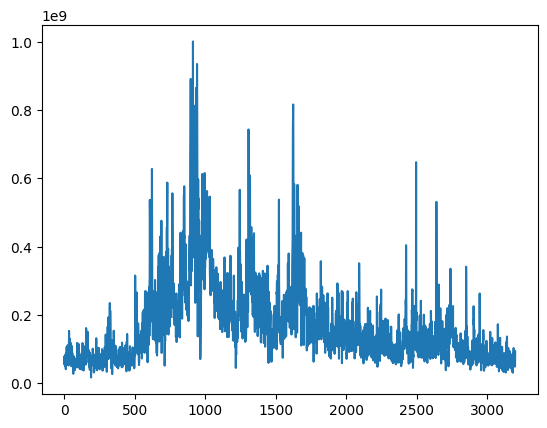

In [502]:
import math

sp500=pd.read_csv('spy.us.txt')
Timestamp = []
quarter = []
first = datetime.strptime(sp500['Date'][0], '%Y-%m-%d').date()
for index, row in sp500.iterrows():
  date = row['Date']
  t = datetime.strptime(date, '%Y-%m-%d').date()

  Timestamp.append((t-first).days)
  quarter.append(math.ceil(datetime.strptime(date, '%Y-%m-%d').month/3.))

sp500['Constant'] = np.ones(len(sp500))
sp500['Timestamp'] = Timestamp
sp500['Quarter'] = quarter



sp500['nextOpen'] = sp500['Open'].shift(-1)
sp500['nextTimestamp'] = sp500['Timestamp'].shift(-1)
sp500['nextQuarter'] = sp500['Quarter'].shift(-1)

sp500 = pd.get_dummies(sp500,columns=['nextQuarter'], dtype=int)

sp500['t'] = sp500['nextTimestamp']-sp500['Timestamp']

sp500['logOpen'] = np.log(sp500['Open'])
sp500['logHigh'] = np.log(sp500['High'])
sp500['logLow'] = np.log(sp500['Low'])
sp500['logClose'] = np.log(sp500['Close'])
sp500['nextlogOpen'] = np.log(sp500['nextOpen'])


sp500 = sp500.dropna()
sp500 = sp500.drop(columns=['OpenInt'])
train_size = int(len(sp500) * 0.8)
train_train_size = int(train_size * 0.8)

print(sp500)
plt.plot(sp500['Volume'])

['Open', 'High', 'Low', 'Close', 'Volume', 'nextTimestamp', 't', 'nextQuarter_1.0', 'nextQuarter_2.0']
['Open', 'High', 'Low', 'Close', 'Volume', 'nextTimestamp', 't', 'nextQuarter_2.0']
['Open', 'High', 'Low', 'Close', 'Volume', 'nextTimestamp', 'nextQuarter_2.0']
['Open', 'High', 'Low', 'Close', 'Volume', 'nextTimestamp']
['High', 'Low', 'Close', 'Volume', 'nextTimestamp']
['Low', 'Close', 'Volume', 'nextTimestamp']
['Close', 'Volume', 'nextTimestamp']
['Close', 'Volume']
['Close']
[0.5345768204564552, 0.4896821999251079, 0.48106639405409624, 0.47600422027306166, 0.4749571666261522, 0.4759455664965107, 0.4757415876670738, 0.4775675840122639, 0.47974114404480017, 0.48459056702661973]


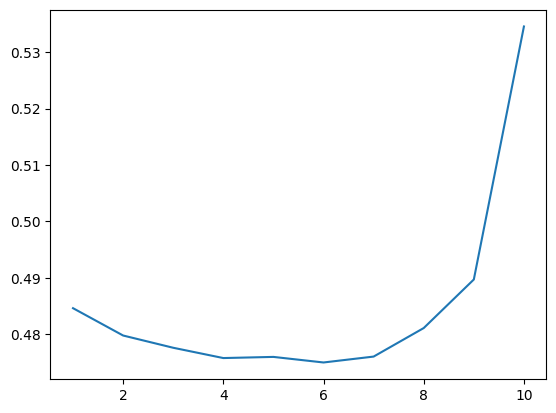

In [521]:
log = False
rolling = False
k = 4
foldsize = int(train_size/k)

if log:
    X_labels = ['logOpen', 'logHigh', 'logLow', 'logClose', 'Volume', 'nextTimestamp', 't', 'nextQuarter_1.0', 'nextQuarter_2.0', 'nextQuarter_3.0']
    y_labels = ['nextlogOpen']
else:
    X_labels = ['Open', 'High', 'Low', 'Close', 'Volume', 'nextTimestamp', 't', 'nextQuarter_1.0', 'nextQuarter_2.0', 'nextQuarter_3.0']
    y_labels = ['nextOpen']

loss = []

def lossfunc(labels):
    regr = linear_model.LinearRegression()
    averageloss = 0

    for i in range(k):
        if rolling:
            if i == k-1: continue
            X = sp500[i*foldsize:(i+1)*foldsize][labels]
            Y = sp500[i*foldsize:(i+1)*foldsize][y_labels]
        else:
            X = sp500[i*foldsize:int((i+0.8)*foldsize)][labels]
            Y = sp500[i*foldsize:int((i+0.8)*foldsize)][y_labels]
        regr.fit(X, Y)


        predicted = regr.predict(sp500[labels]).flatten()

        if log:
            abserror = abs(np.exp(predicted)-sp500['nextOpen'])
        else:    
            abserror = abs(predicted-sp500['nextOpen']) 
        if rolling:
            averageloss += abserror[(i+1)*foldsize:min((i+2)*foldsize,train_size)].mean()/(k-1)
        else:
            averageloss += abserror[int((i+0.8)*foldsize):min((i+1)*foldsize,train_size)].mean()/(k)
    

    return averageloss
    
goals = []

for i in range(len(X_labels)-1):
    
    goal = lossfunc(X_labels)
    goals.append(goal)
    tests = []
    for j in range(len(X_labels)):
        newlabels = [x for x in X_labels if x != X_labels[j]]
        loss = lossfunc(newlabels)
        tests.append(loss)

    argmin = min(enumerate(tests), key=lambda x: x[1])[0]
    del X_labels[argmin]
    print(X_labels)

goals.append(lossfunc(X_labels))
print(goals)

plt.plot(list(range(len(goals),0,-1)), goals)  # Plot the chart
plt.show()  # display


constant: -0.0026385543948288515
coefficients: [0.0380012  0.96254462]
MAE: 0.6783885948210016
MSE: 1.1148015470017227


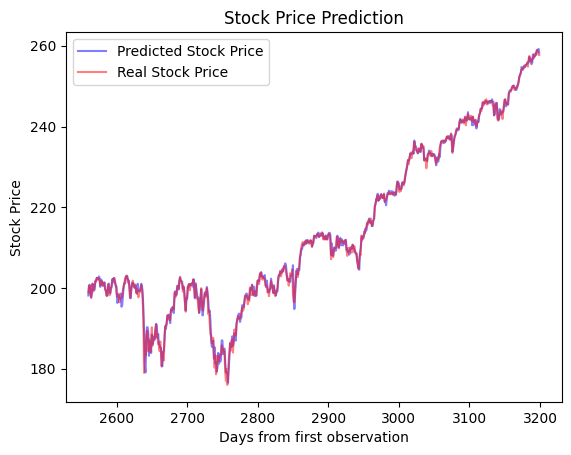

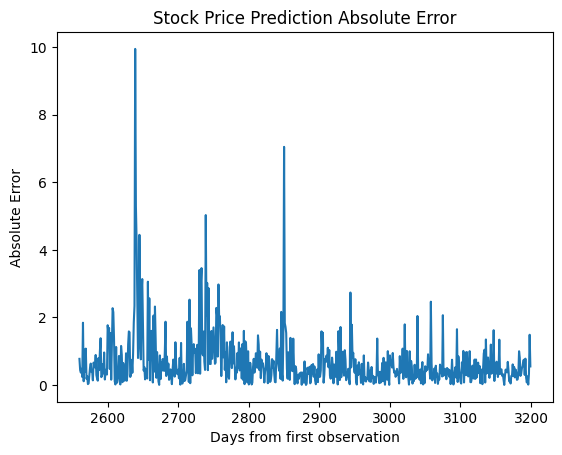

In [520]:
log = True
if log:
    X_labels = ['logHigh', 'logClose']
    y = sp500[:train_size]['nextlogOpen']
else:
    X_labels = ['Close']
    y = sp500[:train_size]['nextOpen']

regr = linear_model.LinearRegression()
X = sp500[:train_size][X_labels]
regr.fit(X, y)
print(f"constant: {regr.intercept_}")
print(f"coefficients: {regr.coef_}")

if log: 
    sp500['predicted'] = np.exp(regr.predict(sp500[X_labels]))
else:
    sp500['predicted'] = regr.predict(sp500[X_labels])



sp500['error'] = sp500['predicted']-sp500['nextOpen']
sp500['abserror'] = abs(sp500['error'])
sp500['squarederror'] = sp500['abserror'] **2

print(f"MAE: {sp500['abserror'][train_size:].mean()}")
print(f"MSE: {sp500['squarederror'][train_size:].mean()}")

plt.plot(sp500[train_size:]['predicted'], alpha=0.5, color='blue', label='Predicted Stock Price')
plt.plot(sp500[train_size:]['nextOpen'], alpha=0.5, color='red', label='Real Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Days from first observation')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
plt.plot(sp500[train_size:]['abserror'])
plt.title('Stock Price Prediction Absolute Error')
plt.xlabel('Days from first observation')
plt.ylabel('Absolute Error')
plt.show()


### (Seasonal) ARIMA approach

ARIMA models are typically the first type of model we consider when trying to model time series data. ARIMA is modelled after the following equation:

$$
Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \cdots + \phi_p Y_{t-p} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q} + \epsilon_t
$$

where:

$$
\Delta^d Y_t = (1 - B)^d Y_t
$$

and

$$
\epsilon_t \sim \text{white noise}
$$

Firstly, we apply normal ARIMA methods. In theory, this model should perform poorly because the data is not stationary meaning the stock price is directly or strongly affected by the date. This makes sense since our only factor so far in the modelling is time. The evidence for our theoretically poor performance of traditional ARIMA on our data set is shown through a p test of whether our data is stationary. We use an Augmented Dickey Fuller hypothesis test to find if there is sufficient evidence against the null hypothesis that our data is stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Check for stationarity using ADF test
result = adfuller(sp500['Price'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Interpretation:
# If p-value < 0.05, the series is stationary.

KeyError: 'Price'

It seems that there may be overwhelming evidence based on the p-value, that the data is not stationary. However, to confirm that this is likely true and not an unusual occurence, we test traditional ARIMA on the data. The metrics we will use to highlight that non-seasonal ARIMA may not be suitable for our context are AIC and BIC values.

Here is a very basic demonstration of a combination of underfitting and inappropriate model choice leading to evidence supporting the alternative hypothesis that non-seasonal ARIMA may not work

In [ ]:
from statsmodels.tsa.arima.model import ARIMA #download using pip
# Assuming your training data is stored in a DataFrame called 'train' with a column named 'Price'
# Fit the ARIMA model
model = ARIMA(sp500_train['Price'], order=(5, 1, 0)) # (p, d, q)
model_fit = model.fit()

# Print model summary
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 7682
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -7562.600
Date:                Thu, 07 Nov 2024   AIC                          15137.200
Time:                        21:14:35   BIC                          15178.879
Sample:                             0   HQIC                         15151.495
                               - 7682                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0929      0.006     16.588      0.000       0.082       0.104
ar.L2          0.0654      0.007      9.639      0.000       0.052       0.079
ar.L3         -0.0841      0.007    -12.476      0.0

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error

# Make predictions on the test data
predictions = model_fit.predict(start=len(sp500_train), end=len(sp500) - 1)

# Calculate evaluation metrics
rmse = mean_squared_error(sp500_test['Price'], predictions, squared=False)
mae = mean_absolute_error(sp500_test['Price'], predictions)
mse = mean_squared_error(sp500_test['Price'], predictions)
mape=mean_absolute_percentage_error(sp500_test['Price'], predictions)

# Print the evaluation metrics
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'MAPE: {mape}')
print(f'AIC: {model_fit.aic}')
print(f'BIC: {model_fit.bic}')
#note that normalisation is unnecesary beecause the scale is consistent and multiple variables are not involved


c:\Users\anton\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


ValueError: Found input variables with inconsistent numbers of samples: [1921, 1918]

We notice that the model performs very poorly from the RMSE, MAE and MSE results even if the MAPE seems to indicate the model's generally good performance. We hypothesise that this is because, as expected from earlier citations, we have high AIC and BIC values attributed to the model's expected failure to capture patterns in our non-stationary data. Another reason for the model's failure is due to its lack of complexity. To intuitively provide stronger evidence against the null hypothesis that traditional ARIMA can capture the trend of stock prices, we use auto arima search on hyperparameter space with our training and validation sets. Note that gridsearch may not be feasible because every hyperparameter is continuous in the model. That being said, the auto arima search we will apply does not definitely provide the 'best' performing ARIMA model over a hyperparameter space either. We use this tool to determine which configuration generates the lowest AIC and BIC for evidence.

In [ ]:
from pmdarima.arima import auto_arima #download using pip

auto_arima(y=sp500_train['Price'],
           start_p=1, start_q=1,
           seasonal=False,
           trace=True #so that you can see what is happening.
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15205.632, Time=2.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15277.092, Time=1.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15213.226, Time=0.81 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15221.299, Time=1.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15277.767, Time=0.45 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15153.085, Time=5.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15188.060, Time=1.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=15136.302, Time=3.59 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=15134.841, Time=1.57 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=15136.442, Time=1.52 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=15138.373, Time=2.52 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=15135.177, Time=0.67 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 22.255 seconds


ARIMA(order=(3, 1, 0), scoring_args={}, suppress_warnings=True)

We note that the AIC is extremely high over the entire hyperparamter space providing consistent evidence against the null hypothesis that the data is stationary. Next we test our other null hypothesis that the data is seasonal using a p-test. We nominated Ljung-Box test because it is purported for assessing goodness of fit to ARIMA models. Here is the process of applying the test:

* Fit the SARIMA model to the data
* Calculate the residuals
* Perform the Ljung-Box test on the residuals
* Interpret results

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

# Fit the SARIMA model
model = SARIMAX(sp500_train['Price'], order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))  # (p, d, q), (P, D, Q, s)
model_fit = model.fit()

# Generate residuals
residuals = model_fit.resid

# Conduct Ljung-Box test on the residuals
lb_test = acorr_ljungbox(residuals, lags=[10, 20])  # You can adjust the lags

print(lb_test)

       lb_stat      lb_pvalue
10    1.272756   9.994861e-01
20  790.852625  1.236900e-154


We note that the p value is extremely high indicating sufficient evidence against the null. Next, we provide some evidence that ascertains whether the SARIMA model is indeed not a good fit to the data.

In [ ]:
# #takes a long time and will crash however all we need from this is an indicator that AIC scores are consistently high
# auto_arima(y=sp500_train['Price'],
#            start_p=1, start_q=1,
#            seasonal = True,
#            m=15,#cycle size one month
#            trace=True #so that you can see what is happening.
# )

We see consistently high AIC values, suggesting that the data is not seasonal so this model is an inappropriate choice to select on its own. Let us explore the next model choice.

### GARCH approach

### Neural Network (CNN, RNN and LSTM) approach


### Hybrid approach

## Evaluation and Discussion

## Conclusion